In [170]:
import re
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

mu_sol = 1.32712440018e11  # km^3/s^2

In [171]:
def read_parameters(date, filename='cassini_all_orbit.txt'):
    """
    Lê o arquivo de dados e retorna todos os parâmetros para uma data específica

    Args:
        date (str): Data no formato 'ano-Mes-dia'
        filename (str): Nome do arquivo de dados

    Returns:
        dict: Dicionário com todos os parâmetros orbitais
    """

    with open(filename, 'r') as file:
        content = file.read()

    pattern = rf'(\d+\.\d+) = A\.D\. {date}.*?(?=\n\d+\.\d+ = A\.D\.|\Z)'
    match = re.search(pattern, content, re.DOTALL)

    if not match:
        raise ValueError(f"Data {date} não encontrada no arquivo")

    block = match.group(0)

    params = {}

    jd_match = re.search(r'(\d+\.\d+) = A\.D\.', block)
    if jd_match:
        params['JDTDB'] = float(jd_match.group(1))

    param_pattern = r'([A-Za-z]+)\s*=\s*([-+]?\s*\d*\.?\d+(?:[Ee][-+]?\d+)?)'
    matches = re.findall(param_pattern, block)

    for key, value in matches:
        value_clean = re.sub(r'\s+', '', value)
        params[key] = float(value_clean)

    return params


In [172]:
def print_parameters(date, filename='cassini_all_orbit.txt'):
    """
    Lê e imprime todos os parâmetros para uma data específica
    """
    parametros = read_parameters(date, filename)

    print(f"Parâmetros orbitais para {date}:")
    print("=" * 50)

    # Lista de todos os parâmetros na ordem desejada
    parametros_info = [
        ('JDTDB', 'Julian Day Number, Barycentric Dynamical Time'),
        ('EC', 'Eccentricity, e'),
        ('QR', 'Periapsis distance, q (km)'),
        ('IN', 'Inclination w.r.t X-Y plane, i (degrees)'),
        ('OM', 'Longitude of Ascending Node, OMEGA, (degrees)'),
        ('W', 'Argument of Perifocus, w (degrees)'),
        ('Tp', 'Time of periapsis (Julian Day Number)'),
        ('N', 'Mean motion, n (degrees/sec)'),
        ('MA', 'Mean anomaly, M (degrees)'),
        ('TA', 'True anomaly, nu (degrees)'),
        ('A', 'Semi-major axis, a (km)'),
        ('AD', 'Apoapsis distance (km)'),
        ('PR', 'Sidereal orbit period (sec)')
    ]

    for key, description in parametros_info:
        if key in parametros:
            if key == 'JDTDB':
                print(f"{key:4} = {parametros[key]:.6f} # {description}")
            else:
                print(f"{key:4} = {parametros[key]:.15e} # {description}")
        else:
            print(f"{key:4} = NÃO ENCONTRADO # {description}")

In [173]:
def excentricity(r1, theta1, r2, theta2):
    return abs((r2 - r1) / (r1*np.cos(theta1) - r2*np.cos(theta2)))

def semiaxis(r, e, theta):
    return r * (1 + e * np.cos(theta)) / (1 - e**2)

def angular_momentum(r, theta, e, mu):
    p = r * (1 + e * np.cos(theta))
    if p<0:
        p = -p
    h = np.sqrt(mu * p)
    return h
    # return np.sqrt(mu * r * (1 + e * np.cos(theta)))

def tangencial_velocity(mu, h, e, theta):
    return mu / h * (1 + e * np.cos(theta))

def radial_velocity(mu, h, e, theta):
    return mu / h * e * np.sin(theta)

def velocity_magnitude(mu, h, e, theta):
    return mu / h * np.sqrt(e**2 + 2*e*np.cos(theta) + 1)

In [174]:
def eccentric_anomaly_from_true_anomaly(theta, e):
    if 0 <= e < 1:

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)

        denominator = 1 + e * cos_theta
        sqrt_value = 1 - e**2
        sin_E = np.sqrt(sqrt_value) * sin_theta / denominator
        cos_E = (e + cos_theta) / denominator

        E = np.arctan2(sin_E, cos_E)
        if E < 0:
            E += 2 * np.pi
        return E


    elif e > 1:

        critical_angle = np.arccos(-1/e)
        if abs(theta - critical_angle) < 1e-10 or abs(theta - (2*np.pi - critical_angle)) < 1e-10:
            # Retornar um valor grande mas finito
            return 10.0 if theta > np.pi else -10.0

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)

        denominator = 1 + e * cos_theta
        if abs(denominator) < 1e-12:
            return 10.0 if theta > np.pi else -10.0

        # Usar a definição de anomalia excêntrica hiperbólica
        H = 2 * np.arctanh(np.sqrt((e - 1) / (e + 1)) * np.tan(theta / 2))
        return H

def mean_anomaly_from_eccentric_anomaly(E, e):
    """Calcula a anomalia média M a partir da anomalia excêntrica E"""
    if e < 1:
        return E - e * np.sin(E)
    else:
        # Para órbitas hiperbólicas
        return e * np.sinh(E) - E

def orbital_period(a, mu):
    return 2 * np.pi * np.sqrt(a**3 / mu)

def time_from_periapsis(theta, e, a, mu):
    """
    Calcula o tempo desde a passagem pelo periastro para uma dada anomalia verdadeira
    Retorna tempo em segundos
    """
    try:
        E = eccentric_anomaly_from_true_anomaly(theta, e)
        M = mean_anomaly_from_eccentric_anomaly(E, e)

        if e < 1:
            n = np.sqrt(mu / abs(a)**3)  # Movimento médio para elípticas
        else:
            # Para órbitas hiperbólicas, usar a definição apropriada
            n = np.sqrt(mu / abs(a)**3)

        return M / n
    except Exception as ex:
        print(f"Erro em time_from_periapsis: {ex}")
        return 0

def calculate_travel_time(theta1, theta2, e, a, mu):
    """
    Calcula o tempo para viajar de theta1 a theta2
    Retorna tempo em dias
    """
    try:
        t1 = time_from_periapsis(theta1, e, a, mu)
        t2 = time_from_periapsis(theta2, e, a, mu)

        # Determinar a direção do movimento
        delta_t = t2 - t1

        # Se delta_t é negativo e é órbita elíptica, a nave passou pelo periastro
        if delta_t < 0 and e < 1:
            T = orbital_period(a, mu)
            delta_t += T

        return delta_t / 86400  # Converter para dias
    except Exception as e:
        print(f"Erro no cálculo do tempo: {e}")
        return 0

In [175]:
def plot_orbit(e, a, theta1, theta2, r1, r2):


    """
    Ta bem ruim o plot

    Plota a órbita elíptica com a parte percorrida em linha contínua

    Args:
        e: excentricidade
        a: semi-eixo maior (km)
        theta1, theta2: anomalias verdadeiras inicial e final (graus)
        r1, r2: raios orbital inicial e final (km)
    """
    # Parâmetros da elipse
    if e < 1:
        b = a * np.sqrt(1 - e**2)  # semi-eixo menor
    elif e > 1:
        b = a * np.sqrt(e**2 - 1)  # semi-eixo menor para hipérbole


    c = e * a  # distância do centro ao foco

    # Gera pontos para a órbita completa
    theta_full = np.linspace(0, 2*np.pi, 1000)
    r_full = a * (1 - e**2) / (1 + e * np.cos(theta_full))

    # Converte para coordenadas cartesianas
    x_full = r_full * np.cos(theta_full)
    y_full = r_full * np.sin(theta_full)

    # Gera pontos para a parte percorrida
    if theta2 > theta1:
        theta_traveled = np.linspace(theta1, theta2, 200)
    else:
        # Se theta2 < theta1, assumimos que passa pelo periastro
        theta_traveled = np.concatenate([
            np.linspace(theta1, 2*np.pi, 100),
            np.linspace(0, theta2, 100)
        ])

    r_traveled = a * (1 - e**2) / (1 + e * np.cos(theta_traveled))
    x_traveled = r_traveled * np.cos(theta_traveled)
    y_traveled = r_traveled * np.sin(theta_traveled)

    # Cria a figura
    plt.figure(figsize=(10, 8))

    # Plot da órbita completa (tracejada)
    plt.plot(x_full, y_full, '--', color='gray', alpha=0.7, label='Órbita completa')

    # Plot da parte percorrida (contínua)
    plt.plot(x_traveled, y_traveled, '-', color='blue', linewidth=2, label='Trajetória percorrida')

    # Marca as posições inicial e final
    plt.plot(r1 * np.cos(theta1), r1 * np.sin(theta1), 'go',
             markersize=8, label=f'Início (θ={theta1:.3f}°)')
    plt.plot(r2 * np.cos(theta2), r2 * np.sin(theta2), 'ro',
             markersize=8, label=f'Fim (θ={theta2:.3f}°)')

    # Marca o Sol no foco
    plt.plot(0, 0, 'yo', markersize=15, label='Sol')
    plt.plot(0, 0, 'y*', markersize=20)

    # Marca o periastro e apoastro
    periastro = a * (1 - e)
    apoastro = a * (1 + e)

    plt.plot([-c, -c], [0, 0], 'kx', markersize=8, label='Centro')
    plt.plot([-c + a, -c - a], [0, 0], 'k--', alpha=0.3)  # Linha do semi-eixo maior

    # Configurações do gráfico
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title(f'Órbita Cassini - {data1} a {data2}\n'
              f'e = {e:.4f}, a = {a/1e6:.1f}×10⁶ km')
    plt.legend()

    # Adiciona informações textuais

    textstr = f'Δθ = {theta2 - theta1:.1f}°\n' \
              f'r₁ = {r1/1e6:.1f}×10⁶ km\n' \
              f'r₂ = {r2/1e6:.1f}×10⁶ km\n' \
              f'Periastro = {periastro/1e6:.1f}×10⁶ km\n' \
              f'Apoastro = {apoastro/1e6:.1f}×10⁶ km'

    plt.annotate(textstr, xy=(0.02, 0.98), xycoords='axes fraction',
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Ajusta os limites para melhor visualização
    max_range = max(apoastro, np.max(np.abs(x_full)), np.max(np.abs(y_full)))
    # plt.xlim(-max_range*1.1, max_range*1.1)
    # plt.ylim(-max_range*1.1, max_range*1.1)

    plt.tight_layout()
    plt.savefig('./Plot_Orbitas/orbita_cassini_' + data1 + '_' + data2 + '.png')
    plt.show()

In [176]:
def dados_da_orbita(start, finish, printa_dados=False, plota_orbita=False):

    data1 = read_parameters(start)
    data2 = read_parameters(finish)

    theta1 = np.radians(data1['TA'])
    theta2 = np.radians(data2['TA'])
    r1 = data1['A'] * (1 - data1['EC']**2) / (1 + data1['EC'] * np.cos(theta1))
    r2 = data2['A'] * (1 - data2['EC']**2) / (1 + data2['EC'] * np.cos(theta2))

    e = excentricity(r1, theta1, r2, theta2)
    a = semiaxis(r1, e, theta1)
    h = angular_momentum(r1, theta1, e, mu_sol)
    vr1 = radial_velocity(mu_sol, h, e, theta1)
    vt1 = tangencial_velocity(mu_sol, h, e, theta1)
    v1 = velocity_magnitude(mu_sol, h, e, theta1)
    vr2 = radial_velocity(mu_sol, h, e, theta2)
    vt2 = tangencial_velocity(mu_sol, h, e, theta2)
    v2 = velocity_magnitude(mu_sol, h, e, theta2)
    real_time = (data2['JDTDB'] - data1['JDTDB']) # em dias
    theoretical_time = calculate_travel_time(theta1, theta2, e, a, mu_sol)
    erro_percentual = abs((theoretical_time - real_time) / real_time) * 100

    if printa_dados:
        print()
        print(f"Parâmetros calculados entre {start} e {finish}:")
        print("=" * 50)
        print(f"Excentricidade: {e:.15e}")
        print(f"Semi-eixo maior:{a:.15e} km ")
        print(f"Momento angular: {h:.15e} km^2/s ")
        print(f"Velocidade inicial {start}: vr = {vr1:.15e} km/s, vt = {vt1:.15e} km/s, v_total = {v1:.15e} km/s")
        print(f"Velocidade final {finish}: vr = {vr2:.15e} km/s, vt = {vt2:.15e} km/s, v_total = {v2:.15e} km/s")
        print(f"Tempo real de viagem: {real_time:.6f} dias")
        print(f"Tempo teórico de viagem: {theoretical_time:.6f} dias")
        print(f"Erro percentual: {erro_percentual:.6f} %")
        print("=" * 50)
        print()

    if plota_orbita:
        plot_orbit(e, a, theta1, theta2, r1, r2)

    return {
        'e': e,
        'a': a,
        'h': h,
        'theta_1':theta1,
        'theta_2':theta2,
        'vr_start': vr1,
        'vt_start': vt1,
        'v_start': v1,
        'vr_end': vr2,
        'vt_end': vt2,
        'v_end': v2,
        'real_time_days': real_time,
        'theoretical_time_days': theoretical_time,
        'error_percent': erro_percentual
    }

In [177]:
def trajetoria_completa(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6):
    """
    Plota a trajetória completa da Cassini, emendando todas as órbitas em sequência
    """
    # Lista de todas as órbitas
    orbitas = [orbita1, orbita2, orbita3, orbita4, orbita5]#, orbita6]

    # Nomes das órbitas para a legenda
    nomes_orbitas = ['Órbita 1', 'Órbita 2', 'Órbita 3', 'Órbita 4', 'Órbita 5']#, 'Órbita 6']

    # Cores para cada órbita
    cores = ['blue', 'green', 'red', 'orange', 'purple']#, 'brown']

    # Cria a figura
    plt.figure(figsize=(12, 10))

    # Plota cada órbita
    for i, orbita in enumerate(orbitas):
        if orbita is None or np.isnan(orbita['e']) or np.isnan(orbita['a']):
            print(f"Órbita {i+1} não disponível para plotagem")
            continue

        e = orbita['e']
        a = orbita['a']
        theta1 = orbita['theta_1']
        theta2 = orbita['theta_2']

        if theta2 < theta1:
            theta2 += 2*np.pi

        # Gera pontos para a órbita completa
        theta = np.linspace(theta1, theta2, 500)
        r = a * (1 - e**2) / (1 + e * np.cos(theta))

        # Converte para coordenadas cartesianas
        x = r * np.cos(theta)
        y = r * np.sin(theta)

        # Plota a órbita
        plt.plot(x, y, color=cores[i], linewidth=1.5, label=nomes_orbitas[i], alpha=0.7)
        plt.plot(x[theta==2*np.pi], y[theta==2*np.pi], "--", color=cores[i], linewidth=1.5, label=nomes_orbitas[i], alpha=0.7)

        # Marca o início da órbita
        theta_inicio = theta1
        r_inicio = a * (1 - e**2) / (1 + e * np.cos(theta_inicio))
        x_inicio = r_inicio * np.cos(theta_inicio)
        y_inicio = r_inicio * np.sin(theta_inicio)
        plt.plot(x_inicio, y_inicio, 'o', color=cores[i], markersize=5)

        # Marca o fim da órbita
        theta_fim = theta2
        r_fim = a * (1 - e**2) / (1 + e * np.cos(theta_fim))
        x_fim = r_fim * np.cos(theta_fim)
        y_fim = r_fim * np.sin(theta_fim)
        plt.plot(x_fim, y_fim, 's', color=cores[i], markersize=5)

    # Marca o Sol no centro
    plt.plot(0, 0, 'yo', markersize=15, label='Sol')
    plt.plot(0, 0, 'y*', markersize=20)

    # Configurações do gráfico
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Trajetória Completa da Cassini ao Redor do Sol')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adiciona informações sobre as órbitas
    info_texto = "Resumo das Órbitas:\n\n"
    for i, orbita in enumerate(orbitas):
        if orbita is not None and not np.isnan(orbita['e']):
            info_texto += f"{nomes_orbitas[i]}:\n"
            info_texto += f"  e = {orbita['e']:.3f}, a = {orbita['a']/1e6:.1f}×10⁶ km\n"
            info_texto += f"  Tempo: {orbita['real_time_days']:.0f} dias\n"
            info_texto += f"  Erro: {orbita['error_percent']:.1f}%\n\n"

    plt.annotate(info_texto, xy=(0.02, 0.02), xycoords='axes fraction',
                verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=8)

    plt.tight_layout()
    plt.savefig('./Plot_Orbitas/trajetoria_completa_cassini.png')
    plt.show()

In [178]:
def velocity_variation(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6):
    """
    Calcula as variações nas velocidades para cada mudança de orbita
    """
    # Lista de todas as órbitas
    orbitas = [orbita1, orbita2, orbita3, orbita4, orbita5]#, orbita6]
    deltav_r = []
    delatv_t = []
    deltav_total = []

    # pares
    for i in range(len(orbitas)-1):

        vr_final_1 = orbitas[i]['vr_end']
        vt_final_1 = orbitas[i]['vt_end']

        vr_inicial_2 = orbitas[i+1]['vr_start']
        vt_inicial_2 = orbitas[i+1]['vt_start']

        deltav_r.append(vr_inicial_2 - vr_final_1)
        delatv_t.append(vt_inicial_2 - vt_final_1)
        deltav_total.append(math.sqrt((vr_inicial_2 - vr_final_1)**2 + (vt_inicial_2 - vt_final_1)**2))


    return {
        'delta_v_r': np.array(deltav_r),
        'delta_v_t': np.array(delatv_t),
        'delta_v_total': np.array(deltav_total)
        }


In [179]:
orbita1 = dados_da_orbita('1997-Oct-16', '1998-Apr-26', printa_dados=False, plota_orbita=False)
orbita2 = dados_da_orbita('1998-Apr-26', '1998-Dec-03', printa_dados=False, plota_orbita=False)
orbita3 = dados_da_orbita('1998-Dec-03', '1999-Jun-24', printa_dados=False, plota_orbita=False)
orbita4 = dados_da_orbita('1999-Jun-24', '1999-Aug-18', printa_dados=False, plota_orbita=False)
orbita5 = dados_da_orbita('1999-Aug-18', '2000-Dec-30', printa_dados=False, plota_orbita=False)
orbita6 = dados_da_orbita('2000-Dec-30', '2004-Jul-01', printa_dados=True, plota_orbita=False)


Parâmetros calculados entre 2000-Dec-30 e 2004-Jul-01:
Excentricidade: 2.545462744437581e+00
Semi-eixo maior:1.483243703084327e+08 km 
Momento angular: 1.038550948942153e+10 km^2/s 
Velocidade inicial 2000-Dec-30: vr = 1.867395792582217e+01 km/s, vt = -1.385446470545569e+01 km/s, v_total = 2.325215897266518e+01 km/s
Velocidade final 2004-Jul-01: vr = 2.528914252238003e+01 km/s, vt = -7.678582383038931e+00 km/s, v_total = 2.642917624388557e+01 km/s
Tempo real de viagem: 1279.000000 dias
Tempo teórico de viagem: nan dias
Erro percentual: nan %



C:\Users\danil\AppData\Local\Temp\ipykernel_8832\480826826.py:33: RuntimeWarning: invalid value encountered in arctanh
  H = 2 * np.arctanh(np.sqrt((e - 1) / (e + 1)) * np.tan(theta / 2))


In [182]:
print_parameters('2000-Dec-30')

Parâmetros orbitais para 2000-Dec-30:
JDTDB = 2451908.500000 # Julian Day Number, Barycentric Dynamical Time
EC   = 8.029888606606865e-01 # Eccentricity, e
QR   = 1.424082503429471e+08 # Periapsis distance, q (km)
IN   = 7.131066736811708e-01 # Inclination w.r.t X-Y plane, i (degrees)
OM   = 1.462011636467483e+02 # Longitude of Ascending Node, OMEGA, (degrees)
W    = 1.371629927795123e+02 # Argument of Perifocus, w (degrees)
Tp   = 2.451405406917518e+06 # Time of periapsis (Julian Day Number)
N    = 1.074018834480576e-06 # Mean motion, n (degrees/sec)
MA   = 4.668463694150053e+01 # Mean anomaly, M (degrees)
TA   = 1.449635322641733e+02 # True anomaly, nu (degrees)
A    = 7.228436464076109e+08 # Semi-major axis, a (km)
AD   = 1.303279042472275e+09 # Apoapsis distance (km)
PR   = 3.351896525856603e+08 # Sidereal orbit period (sec)


In [186]:
print_parameters('2004-Jul-01')

Parâmetros orbitais para 2004-Jul-01:
JDTDB = 2453187.500000 # Julian Day Number, Barycentric Dynamical Time
EC   = 1.015467691307057e+00 # Eccentricity, e
QR   = 2.424940731061177e+08 # Periapsis distance, q (km)
IN   = 1.384756896326047e+02 # Inclination w.r.t X-Y plane, i (degrees)
OM   = 2.868388294389212e+02 # Longitude of Ascending Node, OMEGA, (degrees)
W    = 5.149031791751248e+01 # Argument of Perifocus, w (degrees)
Tp   = 2.452285310236259e+06 # Time of periapsis (Julian Day Number)
N    = 1.063322494064234e-08 # Mean motion, n (degrees/sec)
MA   = 8.288513306209853e-01 # Mean anomaly, M (degrees)
TA   = 1.289705065419056e+02 # True anomaly, nu (degrees)
A    = -1.567745750107544e+10 # Semi-major axis, a (km)
AD   = 9.999999999999998e+99 # Apoapsis distance (km)
PR   = 9.999999999999998e+99 # Sidereal orbit period (sec)


In [180]:
velocity_variation(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6)

{'delta_v_r': array([ 5.55270313, -0.0443064 , -6.90242896,  2.28594618]),
 'delta_v_t': array([2.09691328, 0.44763579, 4.75250864, 0.26736216]),
 'delta_v_total': array([5.93544921, 0.44982314, 8.38032601, 2.30152829])}

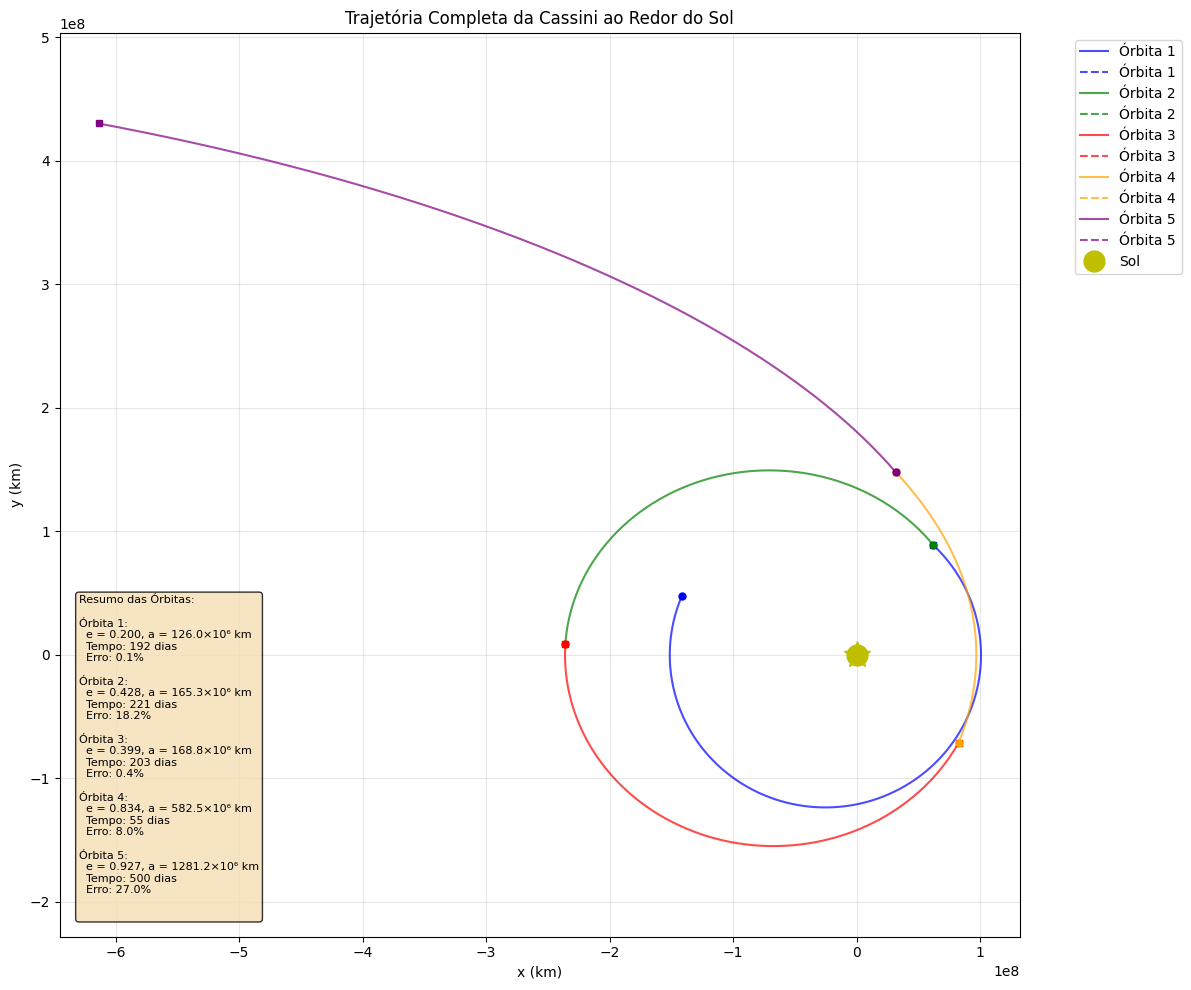

In [181]:
trajetoria_completa(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6)